In [1]:
using DifferentialEquations, Plots, Flux, DiffEqFlux, Optim, BlackBoxOptim
using Turing, DiffEqBayes, Distributions, StatsPlots

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative /home/nadanai/.julia/packages/CUDAnative/C91oY/src/compatibility.jl:176
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


### Simple inference

In [59]:
# Inference requires changing the input parameters of the model.
# This is done using remake()

# Solve the LV equations as before
# Define gradients
function lotka_volterra!(du,u,p,t) 
    R,W = u 
    α,β,γ,δ = p
    du[1] = dR = α*R - β*R*W
    du[2] = dW = γ*R*W - δ*W
end

# Set initial conditions, params, time span, and solve
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra!,u0,tspan,p)
sol = solve(prob, saveat=0.1); # Now we make time points consistent throughout by fixing saveat

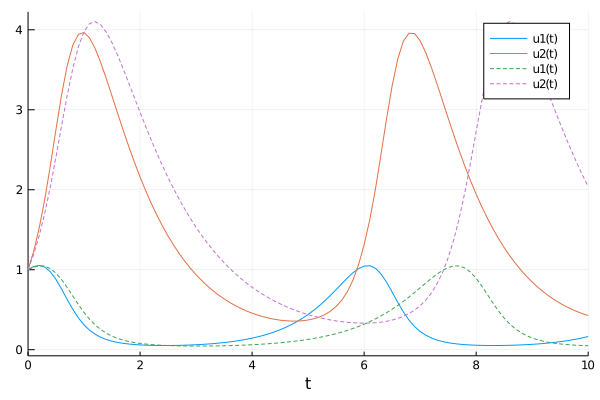

In [60]:
# Plot our solution
plot(sol)
mod_prob = remake(prob, p=[1.2,0.8,2.5,0.8]) # Remake the problem with new parameters
mod_sol = solve(mod_prob, saveat=0.1)

# Plot the solution with new parameters
plot!(mod_sol,ls=:dash)

In [61]:
# Let's use an optimizer to determine ground-truth parameters
# For this we use DiffEqFlux 

dataGroundTruth = Array(sol)

# First define a loss function
function loss(p)
    mod_prob = remake(prob,p=p)
    mod_sol = solve(mod_prob, saveat=0.1,verbose=false) # Verbosity can be set to true to 
                                                        # see error messages during optimization
                                                        # resulting from e.g. maxiterations or convergence
    sum(abs2, Array(mod_sol)-dataGroundTruth) # Sum of absolute squares
end

pinit = [1.2,0.8,2.5,0.8] # Initial value of params
res = DiffEqFlux.sciml_train(loss,pinit,BFGS()) # Minimize loss using BFGS optimizer. Many options available.

# We can get the final parameters from the res object.
# Our original parameters were p = [1.5,1.0,3.0,1.0]
res.minimizer

4-element Array{Float64,1}:
 1.500000000000963
 1.000000000000803
 3.000000000000536
 0.9999999999995162

loss: 2.87: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Saved animation to 
│   fn = /run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_ADAM.gif
└ @ Plots /home/nadanai/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_ADAM.gif")
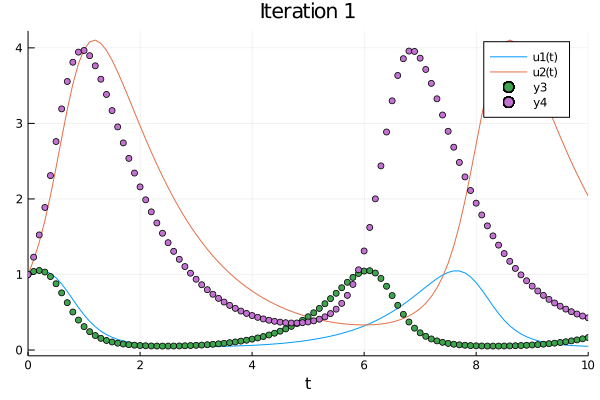

In [62]:
# We can look at the fitting process directly by returning values
# from each step of the optimization and plotting
# This looks nice but is quite slow so you wouldn't want to do it for big jobs

frames = []
function save_callback(p,l)
    mod_prob = remake(prob,p=p)
    mod_sol = solve(mod_prob, saveat=0.1)
    push!(frames,mod_sol)
    false
end

res = DiffEqFlux.sciml_train(loss,pinit,ADAM(0.01),cb=save_callback,maxiters=100)

anim = @animate for i in 1:length(frames)
    plot(frames[i], title="Iteration $i")
    scatter!(sol.t,dataGroundTruth')
end

gif(anim,"fit_ADAM.gif",fps=15)

### Bayesian inference

In [27]:
# We can do Bayesian inference using Turing.jl
# In current development: https://turing.ml/dev/
# Has Gibbs, HMC, HMCDA, importance sampling, NUTS
# particle Gibs, SMC
# You can also program your own sampler: https://turing.ml/dev/docs/for-developers/interface

# Solve the LV equations as before
# Define gradients
function lotka_volterra!(du,u,p,t) 
    R,W = u 
    α,β,γ,δ = p
    du[1] = dR = α*R - β*R*W
    du[2] = dW = γ*R*W - δ*W
end

# Set initial conditions, params, time span, and solve
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra!,u0,tspan,p)
sol = solve(prob, saveat=0.1); # Make sure time points consistent throughout 
odedata = Array(sol) # Model data

Turing.setadbackend(:forwarddiff) # Details here: forwarddiff ok for small models, for 
                                  # larger models require adjoint 

# Define our probabilistic model
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ] # Draw parameters from prior distribution
    prob = ODEProblem(lotka_volterra!,u0,tspan,p)
    predicted = solve(prob,Tsit5(),saveat=0.1) # 

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ) # σ-normal distribution noise
    end
end

model = fitlv(odedata) # Fit model to synthetic data generated earlier
chain = sample(model, NUTS(.65),1000) # No U turn sampler

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/nadanai/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:20


Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5012  0.0058    0.0003  0.0003  157.4792  0.9997
           β  1.0006  0.0036    0.0002  0.0002  163.5151  1.0021
           γ  2.9986  0.0046    0.0002  0.0003  297.8570  0.9982
           δ  0.9993  0.0031    0.0001  0.0002  161.9823  1.0001
           σ  0.0152  0.0011    0.0000  0.0000  270.0077  0.9995

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

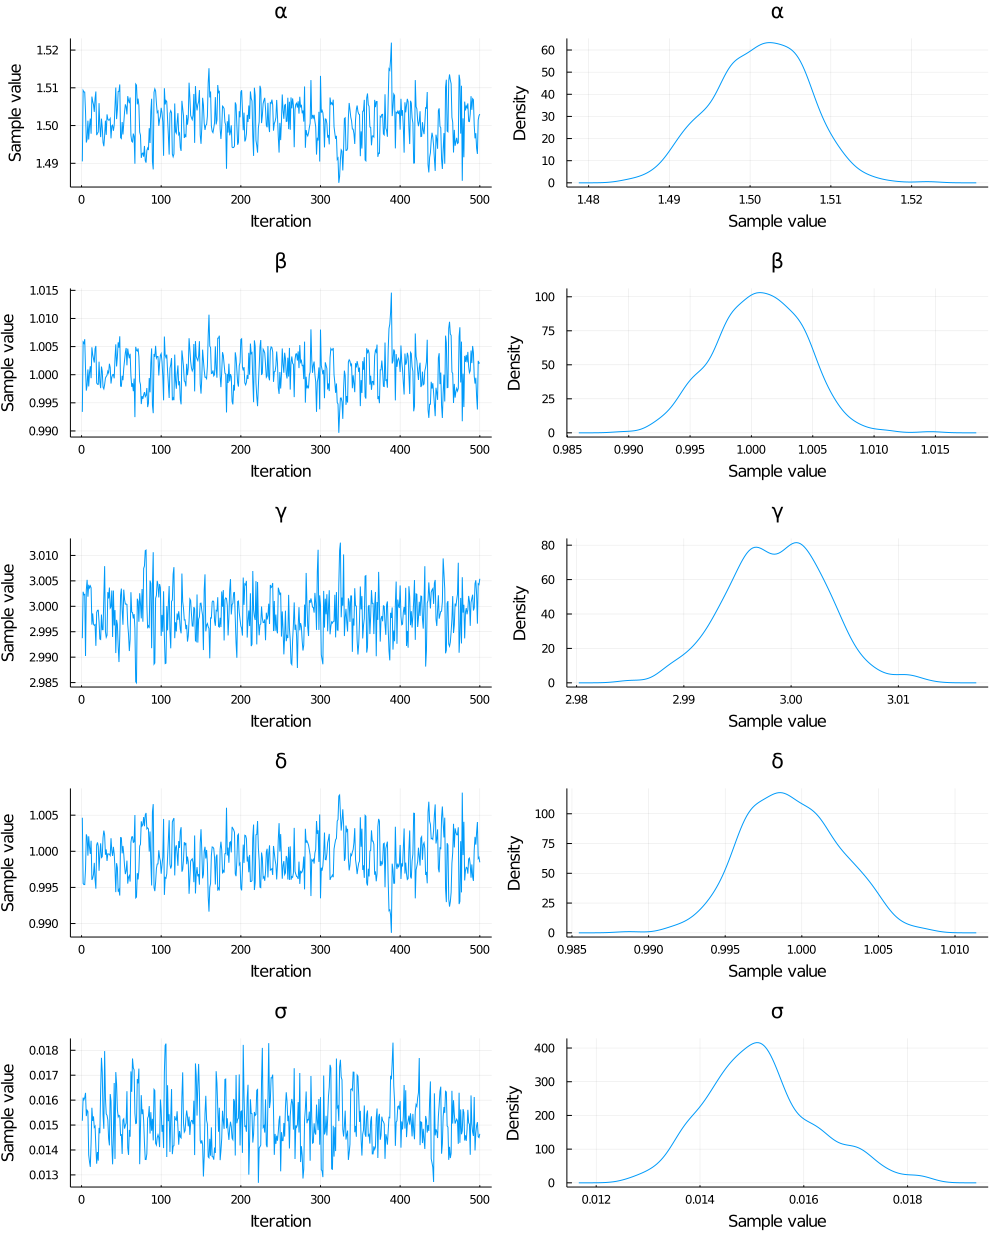

In [28]:
# The chain object contains the samples from the posterior distribution
# For example the samples for parameter α can be accessed:
a = Array(chain[:α].value[:,1,1]);

# The StatsPlots package handles chains automatically. 
# You can get density plots
plot(chain[:α],seriestype=:density);

# Or even a summary of the entire chain object
plot(chain)